<a href="https://colab.research.google.com/github/Jaquelinedops/CICIoT2023/blob/main/Detecting_Malicious_Traffic_over_IoT_SMOTE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IoT application attack predict model

Autora: Jaqueline Duarte

The predict model at https://github.com/Jaquelinedops/CICIoT2023/blob/main/IoTTraffic_DecisionTreeClassifier.ipynb underperformed on the web application attacks

The aim of this study is to find the model with the best perfomance of recall; THis metric is the most appropriate because for an attack detection system, the application is desirable to find all relevant items, even if this means including some irrelevant ones. Since the impact of a false negative can have a much higher cost, becoming an undetected incident, than the cost of a false positive.

In [ ]:
pip install parquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.3/782.3 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
Using cached Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for thriftpy2: filename=thriftpy2-0.5.2-cp310-cp310-linux_x86_64.whl size=1749946 sha256=f96156dde69238500ff35e3f7085e6432c575d2530a37dd87bc2728add270d16
  Stored in directory: /root/.cache/pip/wheels/90/28/5f/279788e86e2eaccb3edc73bde9c815a9527602739a56344ff7
Successfully built thriftpy2


In [ ]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Importando classes e funções para modelos de classificação
from sklearn.tree import DecisionTreeClassifier
# Importando métricas de avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier


# Importando classes e funções para divisão de dados e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.naive_bayes import GaussianNB # Import the GaussianNB class
# Importando bibliotecas de uso geral
import numpy as np
import pandas as pd

# Importando bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score

# Importando biblioteca para salvar e carregar modelos treinados
import joblib
from sklearn.metrics import confusion_matrix
# Importando a biblioteca de deep learning do TensorFlow
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt

import pandas
import numpy
import seaborn
import warnings
import gc
warnings.filterwarnings('ignore')
import os
import parquet
import time




In [ ]:
#importação do dataset, ajuste de tipagem de dados para melhor uso de memória
#Análise Exploratória dos dados disponível em https://github.com/Jaquelinedops/CICIoT2023/blob/main/Analise%20de%20CICIoT23(1).ipynb

def read_dataset(path= "/content/drive/MyDrive/lab/CICIoT2023/",filename = "data.parquet", bool_col_list=[],int_col_list=[]):
  df = pandas.read_parquet(path + filename, engine='pyarrow', memory_map=True)
  gc.collect()
  df[bool_col_list] = df[bool_col_list].astype('int8')
  df[int_col_list] = df[int_col_list].astype('int32')
  gc.collect()
  return df

def generate_train_test_split(df, X_columns = [], test_size=0.2, random_state=10):
  X = df[X_columns]
  Y = df['label']
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, test_size=test_size)
  gc.collect()
  return X_train, X_test, Y_train, Y_test

def barh_plot(df, column_name = "label",lenght = 10, width = 10):
  labels = df[column_name].value_counts().index.to_list()
  composition = df[column_name].value_counts(normalize=True) * 100
  fig, ax = plt.subplots(figsize=(lenght, width))
  ax.barh(labels, composition, color='blue')
  ax.set_xlabel('Percentage', fontsize=16)
  ax.tick_params(labelsize=14)
  ax.set_ylabel('Label', fontsize=16)
  ax.set_title('Data Composition - Percentage of labeled data by class', fontsize=16)
  plt.show()

def calc_metrics(model_name = "model",y_true =[], y_pred=[], start_time=0, end_time=0, average = "weighted"):
  accuracy_clf = accuracy_score(Y_test, y_pred)
  recall = recall_score(Y_test, y_pred, average = average)
  f1 = f1_score(Y_test, y_pred, average = average)
  precision = precision_score(Y_test, y_pred,  average = average)

  results  = { 'model_name': model_name,
             'start_time': start_time,
             'end_time': end_time,
             'accuracy': accuracy_clf,
             'recall': recall,
             'precision':precision,
             'f1-score': f1}
  return results

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  plt.figure(figsize=(25, 25))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



#Importação do parquet - gerado em EDA_CICIoT23.ipynb

The variables were selected as independent, dependent - calculated, boolean, integer as identified in EDA.py



In [ ]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC','Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',]

int_col_list = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
bool_col_list = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']


reading parquet dataset

``````


In [ ]:
path= "/content/drive/MyDrive/lab/CICIoT2023/"
filename = "data.parquet"
df = read_dataset(bool_col_list=bool_col_list,int_col_list=int_col_list)

Data composition from CICIot2023

In [ ]:
def bar_plot(df, column_name = "label",lenght = 10, width = 10):
  labels = df[column_name].value_counts().index.to_list()
  composition = df[column_name].value_counts(normalize=True) * 100
  fig, ax = plt.subplots(figsize=(lenght, width))
  ax.bar(labels, composition, color='blue')
  ax.set_ylabel('Percentage', fontsize=16)
  ax.tick_params(labelsize=14)
  ax.set_xlabel('Label', fontsize=16)
  ax.set_title('Data Composition - Percentage of labeled data by class', fontsize=16)
  plt.xticks(rotation=60, ha='right',fontsize=16)
  plt.grid(axis='y')
  plt.show()

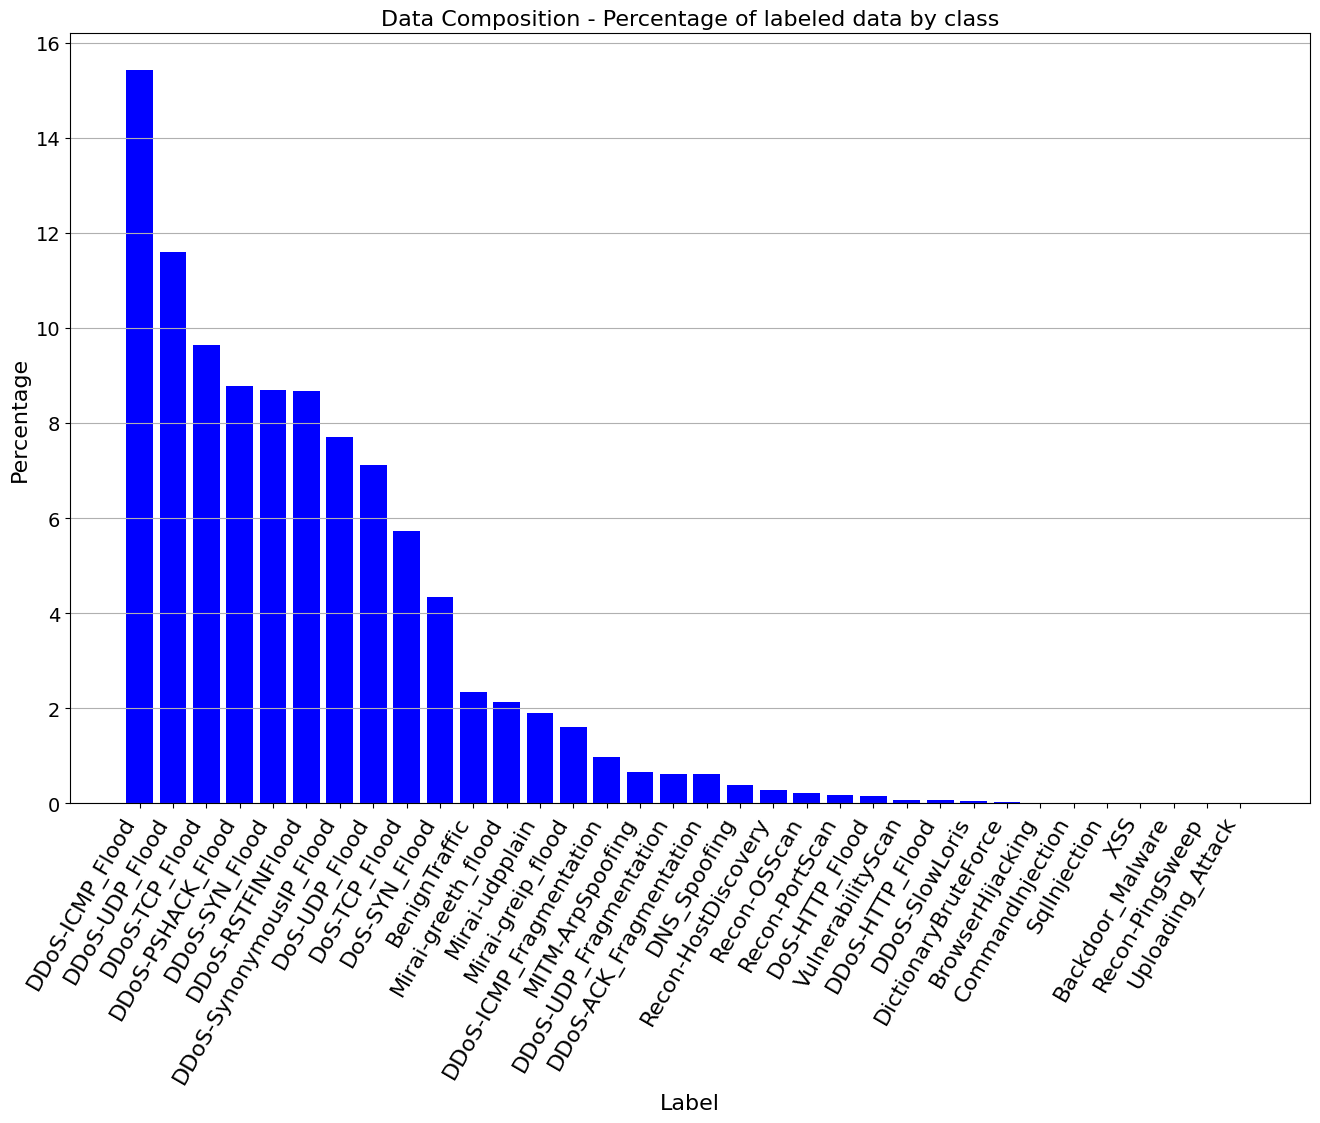

In [ ]:
bar_plot(df,lenght = 16, width = 10)

Split data into train and test dataset

Undersampling the train dataset

In [ ]:
X_train, X_test, Y_train, Y_test = generate_train_test_split(df, X_columns, test_size=0.2, random_state=10)
train_df = X_train
train_df['label'] = Y_train
test_df = X_test
test_df['label'] = Y_test

In [ ]:
def get_x_elements_of_each_label(df, column_name='label', num_elements=15000):
  result_df = pd.DataFrame()
  for label in df[column_name].unique():
    label_df = df[df[column_name] == label]
    num_to_take = min(num_elements, len(label_df))
    sampled_df = label_df.sample(n=num_to_take, random_state=10)  # Use a random state for reproducibility
    result_df = pd.concat([result_df, sampled_df])

  return result_df

sampled_df = get_x_elements_of_each_label(train_df, column_name='label', num_elements=15000)
gc.collect()

0

In [ ]:
sampled_df.label.value_counts()

,count
label,
DDoS-PSHACK_Flood,15000
DDoS-ICMP_Flood,15000
Mirai-udpplain,15000
DDoS-UDP_Flood,15000
DoS-SYN_Flood,15000
BenignTraffic,15000
DDoS-ICMP_Fragmentation,15000
DDoS-SYN_Flood,15000
DDoS-SynonymousIP_Flood,15000


Feature Selection



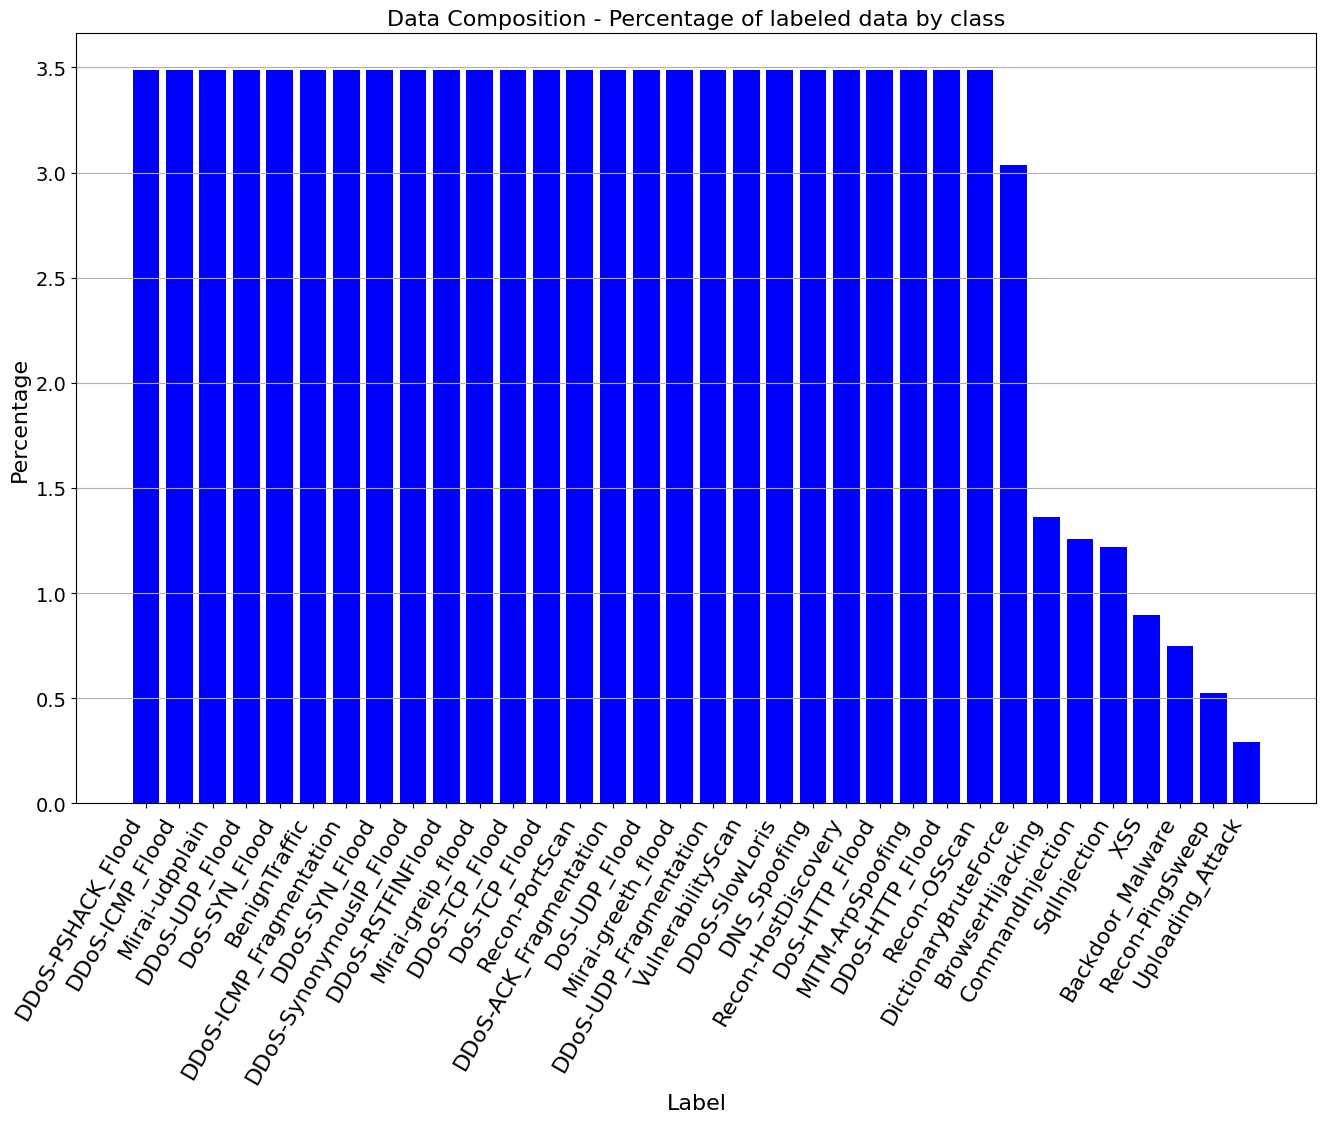

In [ ]:
#Distribuição dos dados
bar_plot(sampled_df, column_name = "label",lenght = 16, width = 10)

# Feature Importance


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(sampled_df[X_columns], sampled_df['label'])

importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({'Feature': X_columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)


In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(feature_importances_df.sort_values('Importance', ascending=False))


            Feature  Importance
39              IAT     0.22219
1     Header_Length     0.06619
2     Protocol Type     0.04829
38         Tot size     0.04811
35              Max     0.04328
36              AVG     0.03652
33          Tot sum     0.03637
18        rst_count     0.03428
34              Min     0.03375
0     flow_duration     0.02995
4              Rate     0.02908
5             Srate     0.02880
41         Magnitue     0.02728
17        urg_count     0.02449
43       Covariance     0.02315
42           Radius     0.02311
8   syn_flag_number     0.02298
37              Std     0.02193
15        syn_count     0.02074
3          Duration     0.02017
7   fin_flag_number     0.01971
30             ICMP     0.01806
45           Weight     0.01789
40           Number     0.01711
10  psh_flag_number     0.01531
11  ack_flag_number     0.01153
19             HTTP     0.01065
26              TCP     0.00927
27              UDP     0.00920
9   rst_flag_number     0.00744
44      

In [ ]:
X_new = feature_importances_df[feature_importances_df["Importance"]>0.001].Feature.to_list()
X_test = test_df[X_new]
Y_test = test_df["label"]

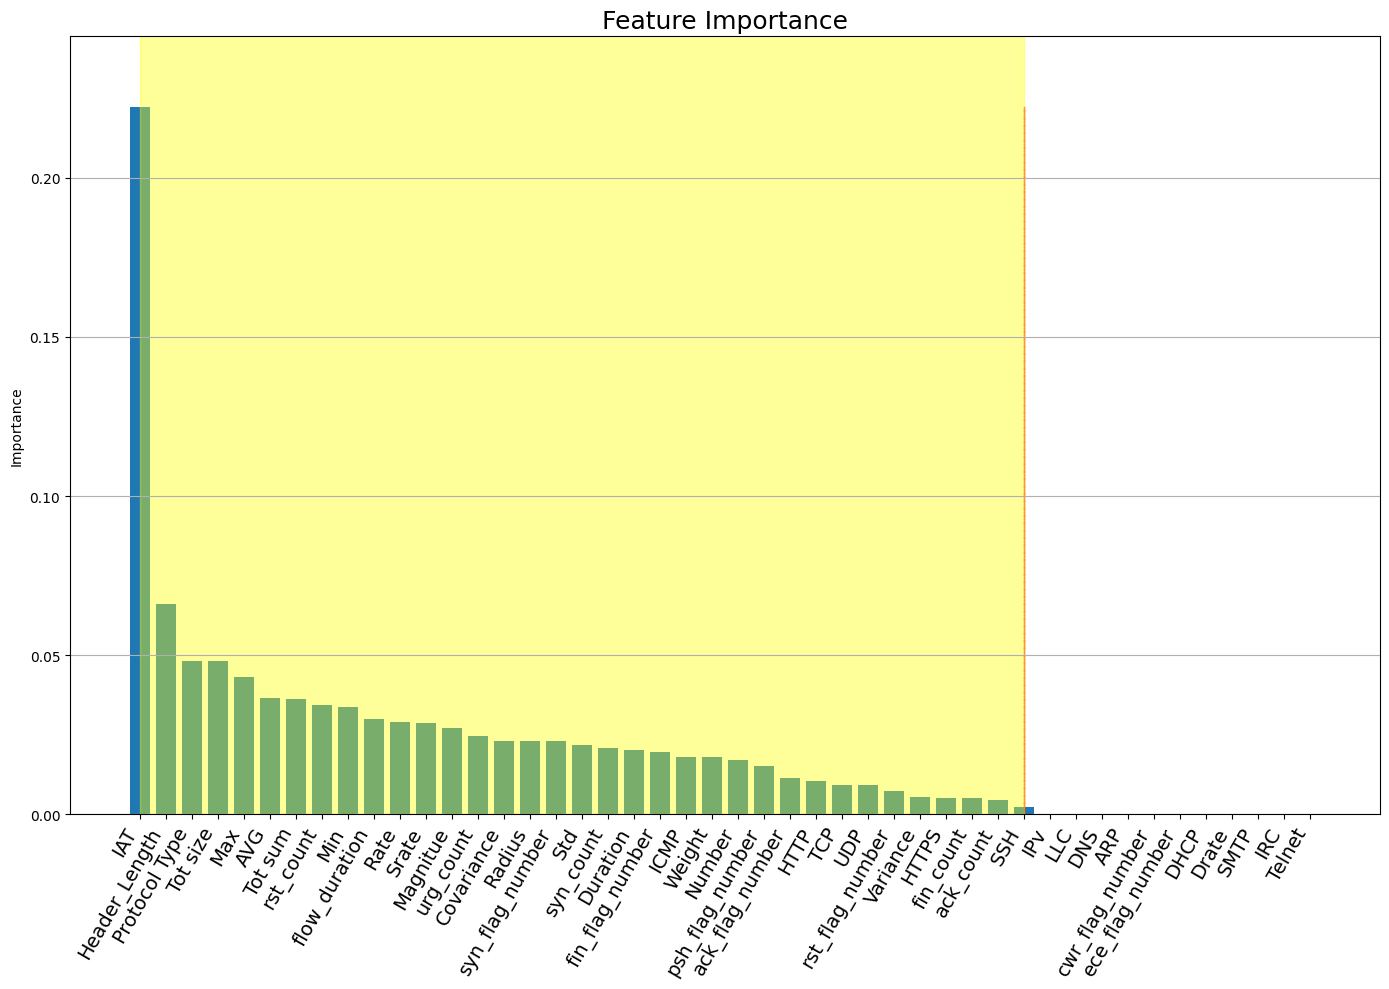

In [ ]:
plt.figure(figsize=(14, 10))
plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.ylabel('Importance')
plt.title('Feature Importance',fontsize=18)
plt.xticks(rotation=60, ha='right',fontsize=14)
plt.xticks(fontsize=14)

plt.grid(True, axis='y')
plt.ylim(0, feature_importances_df['Importance'].max() * 1.1)
plt.tight_layout() # Add this line to automatically adjust spacing
plt.fill_between( 'SSH',feature_importances_df['Importance'].max(), color='red', alpha=0.8, linestyle='--')

y_indices = feature_importances_df[feature_importances_df['Importance'].between(0.002, 100)].index.to_list()
if y_indices:
  plt.fill_betweenx((0, 10.0), 'SSH', 'IAT', color='yellow', alpha=0.4)
plt.show()




Balancing the dataset didn't improve the model recall result, so here we apply oversampling augmentation methodology, particularly using the SMOTE (Synthetic Minority Oversampling Technique) algorithm to the train dataset

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(sampled_df[X_new], sampled_df['label'])

resampled_df = pd.DataFrame(X_resampled, columns=X_new)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')
gc.collect()

17708

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

resampled_df = pd.DataFrame(X_resampled, columns=X_new)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')
gc.collect()


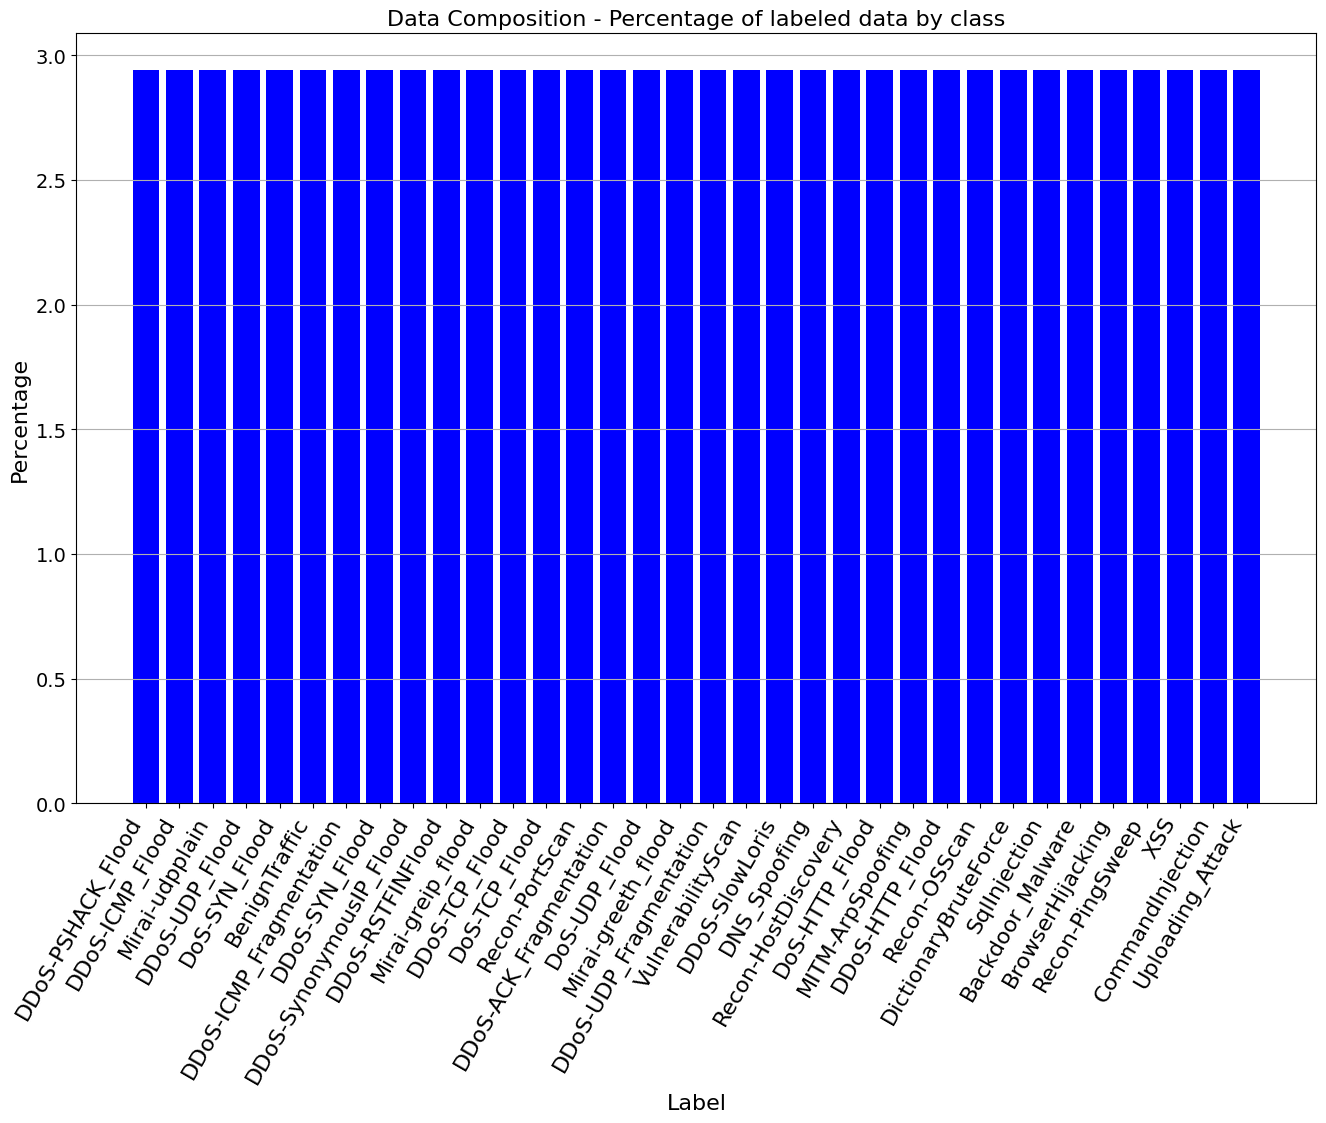

In [ ]:
bar_plot(resampled_df, column_name = "label",lenght = 16, width = 10)

#Training & Evaluating

#Predição sobre labels categorizados por tipo de ataque

# Decision Tree não balanceado

# *Decision Tree*

Training DecisionTreeClassifier best model training without oversampling


In [ ]:
all_reports_df= pd.DataFrame()

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)
random_search.fit(sampled_df[X_new], sampled_df["label"])
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)


best_dt_model = DecisionTreeClassifier(**best_params)
best_dt_model.fit(sampled_df[X_new], sampled_df["label"])

y_pred_best_dt1 = best_dt_model.predict(X_test)

results = calc_metrics(model_name="Decision Tree before oversampling", y_true=Y_test, y_pred=y_pred_best_dt1, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_dt1, output_dict=True, digits=4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 40, 'criterion': 'gini'}


In [ ]:
results

{'model_name': 'Decision Tree',
 'start_time': 0,
 'end_time': 0,
 'accuracy': 0.9908370885166572,
 'recall': 0.9908370885166572,
 'precision': 0.9934132893015255,
 'f1-score': 0.9917153042527418}

In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "Decision Tree before oversampling"
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
report_df

,precision,recall,f1-score,support,model
Uploading_Attack,0.37081,0.70149,0.48516,268.00000,Decision Tree
Recon-PortScan,0.58346,0.70773,0.63961,16536.00000,Decision Tree
Recon-OSScan,0.46381,0.71125,0.56148,19602.00000,Decision Tree
DNS_Spoofing,0.66316,0.76487,0.71039,35976.00000,Decision Tree
Recon-PingSweep,0.20127,0.77778,0.31978,450.00000,Decision Tree
XSS,0.33685,0.80371,0.47474,754.00000,Decision Tree
BenignTraffic,0.96370,0.80729,0.87859,219431.00000,Decision Tree
MITM-ArpSpoofing,0.85576,0.81095,0.83275,61064.00000,Decision Tree
Recon-HostDiscovery,0.83917,0.81401,0.82640,26916.00000,Decision Tree
SqlInjection,0.32377,0.84778,0.46858,1038.00000,Decision Tree


Training DecisionTreeClassifier best model trained on oversampled dataset:

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)
random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

best_dt_model = DecisionTreeClassifier(**best_params)
best_dt_model.fit(X_resampled, y_resampled)
y_pred_best_dt_ov = best_dt_model.predict(X_test)
results = calc_metrics(model_name="Decision Tree final", y_true=Y_test, y_pred=y_pred_best_dt_ov, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_dt_ov, output_dict=True, digits=4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 40, 'criterion': 'gini'}


In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "Decision Tree (oversampling)"
all_reports_df = pd.concat([all_reports_df, report_df])


In [ ]:
results

{'model_name': 'Decision Tree final',
 'start_time': 0,
 'end_time': 0,
 'accuracy': 0.9907681179473844,
 'recall': 0.9907681179473844,
 'precision': 0.9940425297921259,
 'f1-score': 0.9919895493023984}

In [ ]:
report_df

,precision,recall,f1-score,support,model
Recon-PortScan,0.62406,0.68493,0.65308,16536.00000,Decision Tree (oversampling)
Recon-OSScan,0.48442,0.69330,0.57034,19602.00000,Decision Tree (oversampling)
DNS_Spoofing,0.69843,0.75133,0.72392,35976.00000,Decision Tree (oversampling)
MITM-ArpSpoofing,0.88411,0.79991,0.83991,61064.00000,Decision Tree (oversampling)
Recon-HostDiscovery,0.86578,0.80257,0.83298,26916.00000,Decision Tree (oversampling)
XSS,0.18332,0.80769,0.29882,754.00000,Decision Tree (oversampling)
BenignTraffic,0.96685,0.81007,0.88154,219431.00000,Decision Tree (oversampling)
CommandInjection,0.22930,0.83179,0.35950,1082.00000,Decision Tree (oversampling)
SqlInjection,0.21244,0.84586,0.33959,1038.00000,Decision Tree (oversampling)
Uploading_Attack,0.10699,0.85075,0.19008,268.00000,Decision Tree (oversampling)


# *RandomForest*

RandomForest não balanceado

In [ ]:

param_dist = {
    'n_estimators': [50, 100,150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)
random_search_rf.fit(sampled_df[X_new], sampled_df["label"])
best_params_rf = random_search_rf.best_params_
print("Best hyperparameters:", best_params_rf)

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(sampled_df[X_new], sampled_df["label"])

y_pred_best_rf = best_rf_model.predict(X_test)
results = calc_metrics(model_name="RandomForest", y_true=Y_test, y_pred=y_pred_best_rf, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_rf, output_dict=True, digits=4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}


In [ ]:
best_rf_model = RandomForestClassifier(n_estimators= 50, min_samples_split= 5, min_samples_leaf= 2, max_depth= 30, criterion= 'entropy')
best_rf_model.fit(sampled_df[X_new], sampled_df["label"])

y_pred_best_rf = best_rf_model.predict(X_test)
results = calc_metrics(model_name="RandomForest", y_true=Y_test, y_pred=y_pred_best_rf, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_rf, output_dict=True, digits=4)

In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "RandomForest"
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
report_df[report_df["model"] == "RandomForest"]

,precision,recall,f1-score,support,model
Recon-OSScan,0.51773,0.72105,0.60270,19602.00000,RandomForest
Recon-PortScan,0.64840,0.76984,0.70392,16536.00000,RandomForest
DNS_Spoofing,0.74474,0.78683,0.76521,35976.00000,RandomForest
MITM-ArpSpoofing,0.91396,0.82350,0.86637,61064.00000,RandomForest
BenignTraffic,0.96633,0.85273,0.90599,219431.00000,RandomForest
Recon-HostDiscovery,0.83948,0.86893,0.85395,26916.00000,RandomForest
macro avg,0.79894,0.96040,0.84850,9337316.00000,RandomForest
Uploading_Attack,0.84365,0.96642,0.90087,268.00000,RandomForest
Recon-PingSweep,0.52977,0.96889,0.68500,450.00000,RandomForest
BrowserHijacking,0.37876,0.98865,0.54770,1234.00000,RandomForest


In [ ]:
results

{'model_name': 'RandomForest',
 'start_time': 0,
 'end_time': 0,
 'accuracy': 0.9908136342392182,
 'recall': 0.9908136342392182,
 'precision': 0.9932212433145834,
 'f1-score': 0.9916286946295062}


# Getting the best Random Forest Classifier model from RandomizedSearchCV  for oversampled data




In [ ]:

param_dist = {
    'n_estimators': [50, 100,150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)
random_search_rf.fit(X_resampled, y_resampled)
best_params_rf = random_search_rf.best_params_
print("Best hyperparameters:", best_params_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}


In [ ]:
best_rf_model = RandomForestClassifier(**best_params_rf)
best_rf_model.fit(X_resampled, y_resampled)
y_pred_best_rf_ov = best_rf_model.predict(X_test)
results = calc_metrics(model_name="RandomForest (oversampling)", y_true=Y_test, y_pred=y_pred_best_rf_ov, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_rf_ov, output_dict=True, digits=4)

In [ ]:
print("Best hyperparameters:", best_params_rf)

Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}


In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "RandomForest (oversampling)"
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
results

{'model_name': 'RandomForest (oversampling)',
 'start_time': 0,
 'end_time': 0,
 'accuracy': 0.9899615692560902,
 'recall': 0.9899615692560902,
 'precision': 0.993562587153849,
 'f1-score': 0.991272044707461}

In [ ]:
report_df

# Bernoulli Naive Bayes best model for oversampled dataset


In [ ]:

param_dist = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'binarize': [0.0, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Create a BernoulliNB classifier
clf = BernoulliNB()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit the randomized search to the training data
random_search.fit(X_resampled, y_resampled)



NameError: name 'BernoulliNB' is not defined

In [ ]:
# Print the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)
best_params_nb = random_search.best_params_
best_nb_model = BernoulliNB(**best_params_nb)
best_nb_model.fit(X_resampled, y_resampled)

y_pred_best_nb = best_nb_model.predict(X_test)


In [ ]:
results = calc_metrics(model_name="BernoulliNB sampled", y_true=Y_test, y_pred=y_pred_best_nb, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_nb, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "BernoulliNB sampled"


In [ ]:
report_df

In [ ]:
results = calc_metrics(model_name="BernoulliNB sampled", y_true=Y_test, y_pred=y_pred_best_nb, start_time=0, end_time=0)
results



```
# DecisionTreeClassifier aplicado sobre a base de treino sem oversampling




In [ ]:
best_dt_model = DecisionTreeClassifier(min_samples_split= 5, min_samples_leaf= 2, max_depth= 40, criterion= 'gini')
best_dt_model.fit(train_df[X_new], train_df["label"])
y_pred_best_dt = best_dt_model.predict(X_test)
results = calc_metrics(model_name="Decision Tree without sample", y_true=Y_test, y_pred=y_pred_best_dt, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_dt, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "Decision Tree without sample"
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
report_df

In [ ]:
results

In [ ]:
n

# **RandomForestClassifier sobre  a base de dados sem oversampling**

In [ ]:
best_rf_model = RandomForestClassifier(n_estimators= 50, min_samples_split= 5, min_samples_leaf= 2, max_depth= 30, criterion= 'entropy')
best_rf_model.fit(train_df[X_new], train_df["label"])
y_pred_best_rf = best_dt_model.predict(X_test)
results = calc_metrics(model_name="RandomForest", y_true=Y_test, y_pred=y_pred_best_rf, start_time=0, end_time=0)


In [ ]:
report = classification_report(Y_test, y_pred_best_dt, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "RandomForest without sample"
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
results

{'model_name': 'RandomForest',
 'start_time': 0,
 'end_time': 0,
 'accuracy': 0.9983362456620296,
 'recall': 0.9983362456620296,
 'precision': 0.9983362708546791,
 'f1-score': 0.9983100002585091}

In [ ]:
report_df

# Best model for Bernoulli Naive Bayes over dataset without oversampling

In [ ]:
print("Best hyperparameters:", random_search.best_params_)
best_params_nb = random_search.best_params_
best_nb_model = BernoulliNB(**best_params_nb)
best_nb_model.fit(train_df[X_new], train_df['label'])

In [ ]:
y_pred_best_nb = best_nb_model.predict(X_test)
results = calc_metrics(model_name="BernoulliNB without sample", y_true=Y_test, y_pred=y_pred_best_nb, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_nb, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "BernoulliNB "
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
report_df

In [ ]:
results

In [ ]:
all_reports_df.columns = ['Label', 'precision', 'recall', 'f1-score', 'support', 'model']

In [ ]:
# Filter the DataFrame for the two models you want to compare
model1_data = all_reports_df[all_reports_df['model'] == 'RandomForest without sample'].drop_duplicates()
model2_data = all_reports_df[all_reports_df['model'] == 'RandomForest (oversampling)'].drop_duplicates()

# Extract the recall values for each category
categories = model1_data['Label'].tolist()
recall_values_model1 = model1_data['recall'].tolist()
recall_values_model2 = model2_data['recall'].tolist()

# Calculate the average recall for model2
average_recall_model1 = model1_data['recall'].mean()
average_recall_model2 = model2_data['recall'].mean()
best_average_recall_model = average_recall_model1  if average_recall_model1 > average_recall_model2 else average_recall_model2
worst_average_recall_model = average_recall_model1  if average_recall_model1 < average_recall_model2 else average_recall_model2

# Find the index of the maximum recall value in recall_values_model2 where y < average_recall_model2
valid_indices = [i for i, y in enumerate(recall_values_model1) if y < best_average_recall_model]
if valid_indices:
    max_index = max(valid_indices, key=lambda i: recall_values_model1[i])
    max_x = max_index  # Use the index as the x-coordinate for the asymptote
else:
    max_x = None

# Set the width of the bars
bar_width = 0.50

# Set the positions of the bars on the x-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(14, 8))

# Create the bar plot
plt.bar(r1, recall_values_model1, color='orange', width=bar_width, edgecolor='white', label='RandomForest without sample')
plt.bar(r2, recall_values_model2, color='blue', width=bar_width, edgecolor='white', label='RandomForest (oversampling)')

# Add labels, title, and legend
plt.ylabel('Recall', fontsize=16)
plt.title('Comparison of Recall Values by class for balanced and unbalanced train', fontsize=16)
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation=45, ha='right', fontsize=14)
plt.legend()

# Add a horizontal line for the average_recall_model2
plt.axhline(y=worst_average_recall_model, color='red', linestyle='--', label='Average Recall (oversampling)')

# Add a vertical asymptote at the maximum x-coordinate if found and colorize the area below
if max_x is not None:
    plt.axvline(x=max_x + bar_width / 2, color='red', linestyle='--', label='Max Recall (unbalanced) below Average')
    plt.fill_betweenx([0, worst_average_recall_model], 0, max_x + bar_width / 2, color='pink', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()



In [ ]:
# prompt: apply randomized search cv for multinomial Naive bayes classifier  to get best model for best recall

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Multinomial Naive Bayes
param_dist = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Create a MultinomialNB classifier
clf = MultinomialNB()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='recall',  # Use recall as the scoring metric
    random_state=42,  # Set random state for reproducibility
    verbose=2,  # Print progress during fitting
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit the randomized search to the training data (use either resampled or original training data)
# For example, using the resampled data:
random_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)

# Get the best model
best_nb_model = random_search.best_estimator_

# Now you can use best_nb_model to make predictions


In [ ]:
print("Best hyperparameters:", random_search.best_params_)
best_params_nb = random_search.best_params_
best_nb_model = MultinomialNB(**best_params_nb)
best_nb_model.fit(train_df[X_new], train_df['label'])

In [ ]:
y_pred_best_nb = best_nb_model.predict(X_test)
results = calc_metrics(model_name="MultinomialNB without sample", y_true=Y_test, y_pred=y_pred_best_nb, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_nb, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "MultinomialNB "


In [ ]:
report_df[report_df["model"]=="MultinomialNB "]

In [ ]:
results

In [ ]:
print("Best hyperparameters:", random_search.best_params_)
best_params_nb = random_search.best_params_
best_nb_model = MultinomialNB(**best_params_nb)
best_nb_model.fit(X_resampled, y_resampled)
y_pred_best_nb = best_nb_model.predict(X_test)
results = calc_metrics(model_name="MultinomialNB sampled", y_true=Y_test, y_pred=y_pred_best_nb, start_time=0, end_time=0)
report =classification_report(Y_test, y_pred_best_nb, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.sort_values(by="recall")
report_df["model"] = "MultinomialNB "

In [ ]:
all_reports_df = pd.concat([all_reports_df, report_df])

In [ ]:
results

In [ ]:
all_reports_df